<a href="https://colab.research.google.com/github/s1c5000/tensorflow2.0/blob/main/%EC%B4%88%ED%95%B4%EC%83%81%EB%8F%84%EC%9D%B4%EB%AF%B8%EC%A7%80%EC%96%BB%EA%B8%B0_09_4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 초해상도 이미지 얻기

고해상도의 이미지를 저해상도로 변환 하는 것은 쉽지만 반대의 작업은 어려운 연산이다. 픽셀은 디지털 이미지의 최소단위이다. 이미지를 확대했을대 이를 자연스러운 고해상도 이미지로 만들어주는 것이 바로 초해상도(super Resolution)작업이다. 전통적인 알고리즘으로는 주변 값과 비슷한 값으로 보간(interpolation)하는 등의 기법이 있는데 보간기법은 흐릿해지게된다.

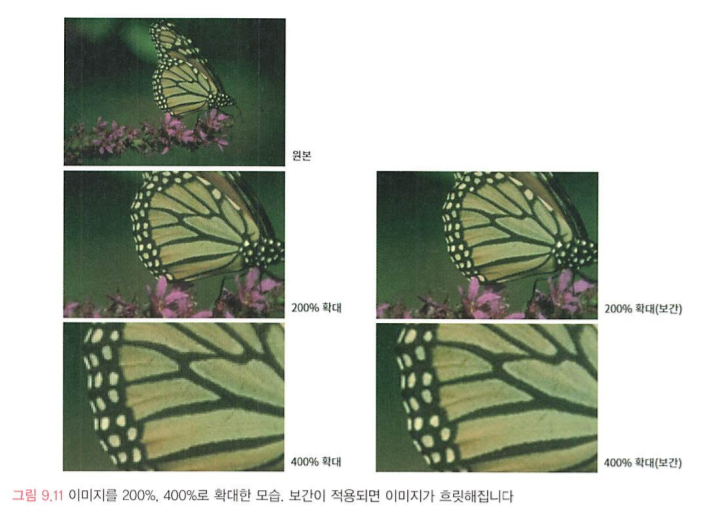

이번 장에서 배운 오토인코더를 활용해서 초해상도 작업을 하는 네트워크를 학습시킬 수 있다. 오토인코더에서 파생된 수많은 네트워크 중에서 이책은 REDNet이라는 네트워크를 사용해 보겠다.     
REDNet은 Residual Encoder Decoder Network의 약자로 Residual은 ResNet등에서 사용하는 건너뛴 연결(skip_connection)이다. 우리말로는 잔류 레이어 라고 부를 수 있다. 다수의 레이어가 중첩되는 구조에서는 앞쪽의 정보를 읽어버리지 않기 위해 뒤쪽에 정보를 그대로 전달해줄 때 건너뛴 연결이 사용된다.

REDNet에는 REDNet-10, REDNet-20, REDNet-30 이 있는데 뒤의 숫자는 컨볼루션 레이어와 디컨볼루션 레이어를 합친 수이다. REDNet-30은 15개의 컨볼루션 레이어와 15개의 디컨볼루션 레이어로 구성된다. 입력과 출력 그리고 그 사이에 존재하는 컨볼루션 레이어와 디컨볼루션 레이어를 거치는 데이터의 크기는 모두 동일하다. 레이어를 많이 사용하기 때문에 앞쪽의 정보를 잃어버리지 않기 위해 2개의 컨볼루션 혹은 디컨볼루션 레이어를 거칠 때마다 건너뛴 연결을 사용한다. 건너뛴 연결은 합연산으로 계산하며 tf.keras에서는 Add레이어를 사용하면 된다. 

논문에서 사용한 이미지는 BSD(Berkely Segmentation Dataset)데이터세트이다. 이 데이터 세트를 사용하겠다

In [ ]:
import tensorflow as tf
import numpy as np
# 9.18 BSD500 데이터세트 불러오기
tf.keras.utils.get_file('/content/bsd_images.zip', 'http://bit.ly/35pHZlC', extract=True)

!unzip /content/bsd_images.zip

37527552/37520292 [==============================] - 0s 0us/step
Archive:  /content/bsd_images.zip
   creating: images/
   creating: images/test/
  inflating: images/test/100007.jpg  
  inflating: images/test/100039.jpg  
  inflating: images/test/100099.jpg  
  inflating: images/test/10081.jpg   
  inflating: images/test/101027.jpg  
  inflating: images/test/101084.jpg  
  inflating: images/test/102062.jpg  
  inflating: images/test/103006.jpg  
  inflating: images/test/103029.jpg  
  inflating: images/test/103078.jpg  
  inflating: images/test/104010.jpg  
  inflating: images/test/104055.jpg  
  inflating: images/test/105027.jpg  
  inflating: images/test/106005.jpg  
  inflating: images/test/106047.jpg  
  inflating: images/test/107014.jpg  
  inflating: images/test/107045.jpg  
  inflating: images/test/107072.jpg  
  inflating: images/test/108004.jpg  
  inflating: images/test/108036.jpg  
  inflating: images/test/108069.jpg  
  inflating: images/test/109055.jpg  
  inflating: image

압축이 해제된 파일들은 /content/images 폴더에 아래에 저장된다. 8.1 절에서 사용했던 pathlib를 사용해 모든 이미지의 경로를 하나의 변수에 저장할수 있다.

In [ ]:
# 9.19 이미지 경로 저장 및 확인
import pathlib
image_root = pathlib.Path('/content/images')

all_image_paths = list(image_root.glob('*/*'))
print(all_image_paths[:10])

[PosixPath('/content/images/test/334025.jpg'), PosixPath('/content/images/test/223060.jpg'), PosixPath('/content/images/test/80085.jpg'), PosixPath('/content/images/test/128035.jpg'), PosixPath('/content/images/test/258089.jpg'), PosixPath('/content/images/test/15011.jpg'), PosixPath('/content/images/test/118031.jpg'), PosixPath('/content/images/test/48017.jpg'), PosixPath('/content/images/test/226033.jpg'), PosixPath('/content/images/test/160067.jpg')]


각 이미지의 경로는 루트 디렉터리에서 glob()함수를 사용해 하단의 모든 파일을 불러올 수 있다. 각 파일의 경로는 posixpath라는 객체가 되는데  이 객체에서 경로를 가져오기 위해서는 문자열로 변환하는 str() 함수를 사용하면 된다.      
데이터세트의 이미지가 어떤 형대인지 확인해보겠다

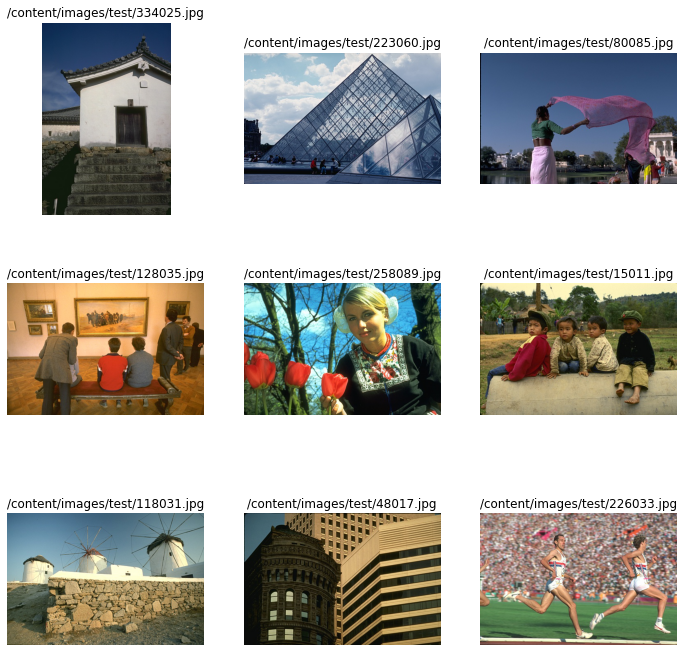

In [ ]:
# 9.20 이미지 확인
import PIL.Image as Image
import matplotlib.pyplot as plt

plt.figure(figsize=(12,12))
for c in range(9):
    plt.subplot(3,3,c+1)
    plt.imshow(plt.imread(all_image_paths[c]))
    plt.title(all_image_paths[c])
    plt.axis('off')
plt.show()

이 데이터들은 외각선을 얻기위해 만들어진 데이터 셋으로 내용에 통일성은 없다.      
200장의 훈련데이터 100장의 검증데이터, 200장의 테스트 데이터로 구성돼 있다. 각 데이터세트의 집합을 처리하기 위한 tf.data.Dataset를 각 데이터세트마다 만들겠다. 그러기 위해 이미지의 경로를 분리해서 저장한다.

In [ ]:
# 9.21 이미지 경로 분리 저장
train_path, valid_path, test_path = [], [], []

for image_path in all_image_paths:
    if str(image_path).split('.')[-1] != 'jpg':
        continue
    
    if str(image_path).split('/')[-2] == 'train':
        train_path.append(str(image_path))
    elif str(image_path).split('/')[-2] == 'val':
        valid_path.append(str(image_path))
    else:
        test_path.append(str(image_path))

tf.data.Dataset를 정의하기 전에 여기서 사용할 함수를 만든다. 혅 가지고 있는 이미지는 고해상도이기 때문에 이미지의 해상도를 일부러 낮추고 원본과 함께 변환하는 함수를 만들겠다. 또 학습 효율을 높이기위해 이미지를 받아온 다음 이미제에서 가로 * 세로 50 픽셀의 작은 조각을 잘라서 학습에 사용하겠다.       
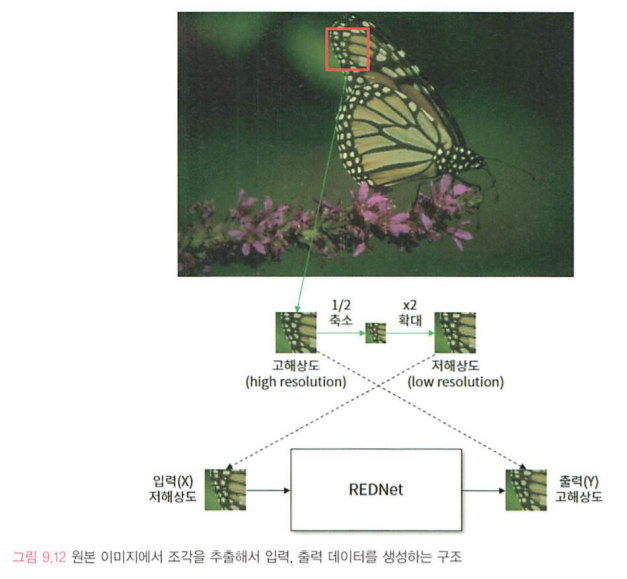

저해상도의 이미지는 입력에 사용되고, 고해상도의 이미지는 출력에 사용된다. 이전 절에서 사용됐던 오토인코더와 달리 이번에 사용되는 입력과 출력은 완전히 같지는 않지만 거의 비슷하기 대문에 오토 인코더가 잘 학습되듯이 이렇게 초해상도 이미지를 얻는 네트워크도 잘 학습된다. 원본 이미지에서 고해상도와 저해상도 조각을 만드는 함수는 예제 9.22에서 정의하겠다.

In [ ]:
# 9.22 원본 이미지에서 조각을 추출하고 입력, 출력 데이터를 반환하는 함수 정의
def get_hr_and_lr(image_path):
    img = tf.io.read_file(image_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.convert_image_dtype(img, tf.float32)

    hr = tf.image.random_crop(img, [50, 50, 3])
    lr = tf.image.resize(hr, [25, 25])
    lr = tf.image.resize(lr, [50, 50])
    return lr, hr

이미지를 불러온 후 decode_jpeg()함수를 사용해서 프로그램이 이해할 수 있는 데이터 형태로 만들어야 하고, convert_image_dtype()함수로 데이터 타입을 딥러닝에서 가장 범용적으로 사용하는 float32로 바꾼다.       
고해상도 이미지는 hr이라는 변수명으로 저장한다. 저해상도 이미지는 축소후 다시 확대하여 lr에 저장한다.       
이제 Dataset을 정의할 차례이다 먼저 학습 과정에서 사용할 훈련 데이터와 검증 데이터를 사용하는 Dataset를 각각 정의한다.

In [ ]:
# 9.23 train, valid Dataset 정의
train_dataset = tf.data.Dataset.list_files(train_path)
train_dataset = train_dataset.map(get_hr_and_lr)
train_dataset = train_dataset.repeat()
train_dataset = train_dataset.batch(16)

valid_dataset = tf.data.Dataset.list_files(valid_path)
valid_dataset = valid_dataset.map(get_hr_and_lr)
valid_dataset = valid_dataset.repeat()
valid_dataset = valid_dataset.batch(1)

먼저 파일의 경로 리스트를 가지고 있다면 tf.data.Dataset.list_files()함수의 인수로 파일경로를 넣어서 Dataset을 정의 할 수 있다. 그 다음 위에서 정한 get_hr_and_lr()함수를 map() 을 적용해 새로운 Dataset을 만든다. 이렇게 연결되면 Dataset는 먼저 train_path리스트의 이미지를 불러온 다음에 저해상도와 고해상도 조각인 lr, hr을 반환한다.      
그다음의 세번째와 네번째 줄에서는 데이터를 반복적으로 사용하기 위한 repeat()함수와 배치 사이즈를 지정하는 batch()함수를 각각 호출한다. valid_dataset도 train_dataset와 거의 비슷하고 마지막 줄의 배치가 1이라는 점만다르다.      


이제 학습시킬 네트워크인 REDNet-30을 정의해 보겠다. 전체 구조는 그림 9.13처럼 컨볼루션 레이어를 15개 쌓은 후 디컨볼루션 레이어를 15개 샇은 단순한 구조이다. 그리고 컨볼루션 레이어와 디컨볼루션 레이어를 각각 2칸씩 건너뛰면서 연결된 합연산이 relu활성화함수를 거쳐서 다음 디 컨볼루션 레이어로 연결된다. 이 연결 방식은 원래 ResNet논문에서 제안된 연결방식과는 조금 다르지만 논문에 따르면 이 방식이 더 효과적이었기 때문에 이것을 사용했다고 한다

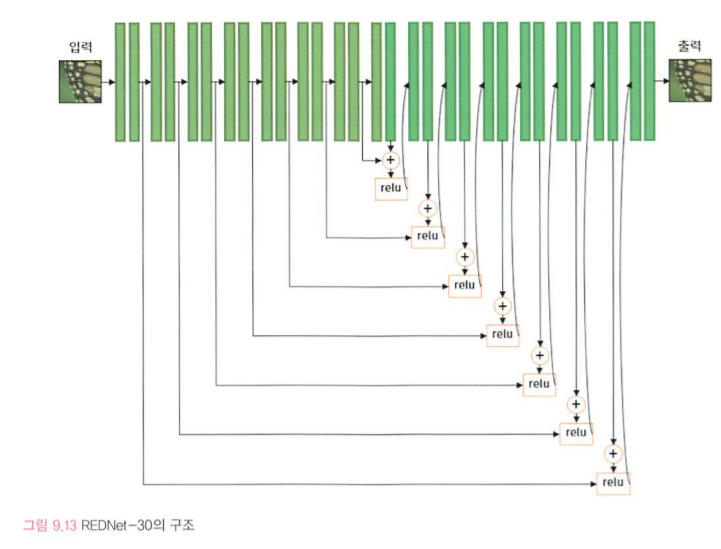

모델의 구조가 직선형이 아니기 때문에 시퀸셜모델이 아닌 함수형 API를 사용해서 네트워크를 정의해야한다. 레이어의 수를 인수로 받는 REDNet()함수를 만들어서 REDNet-(10,20,30)등 다양한 네트워크를 함수 호출 한번으로 만들 수 있다.

In [ ]:
# 9.24 tf.keras의 함수형 API를 사용한 REDNet 네트워크 정의
def REDNet(num_layers):
    conv_layers = []
    deconv_layers = []
    residual_layers = []

    inputs = tf.keras.layers.Input(shape=(None, None, 3))
    conv_layers.append(tf.keras.layers.Conv2D(3, kernel_size=3, padding='same', activation='relu'))

    for i in range(num_layers-1):
        conv_layers.append(tf.keras.layers.Conv2D(64, kernel_size=3, padding='same', activation='relu'))
        deconv_layers.append(tf.keras.layers.Conv2DTranspose(64, kernel_size=3, padding='same', activation='relu'))

    deconv_layers.append(tf.keras.layers.Conv2DTranspose(3, kernel_size=3, padding='same'))

    # 인코더 시작
    x = conv_layers[0](inputs)

    for i in range(num_layers-1):
        x = conv_layers[i+1](x)
        if i % 2 == 0:
            residual_layers.append(x)

    # 디코더 시작
    for i in range(num_layers-1):
        if i % 2 == 1:
            x = tf.keras.layers.Add()([x, residual_layers.pop()])
            x = tf.keras.layers.Activation('relu')(x)
        x = deconv_layers[i](x) 

    x = deconv_layers[-1](x)
    
    model = tf.keras.Model(inputs=inputs, outputs=x)
    return model

함수의 인수인 num_layers는 컨볼루션 레이어와 디컨볼루션 레이어의 수이다. 같은 수의 컨볼루션 레이어와 디컨볼루션 레이어가 존재하기 때문에 REDNet-30이라면 num_layer에 15를 넣으면 된다.    
```
    conv_layers = []
    deconv_layers = []
    residual_layers = []
```
먼저 3개의 리스트에 각각 컨볼루션 레이어, 디컨볼루션 레이어, 잔류(residual)레이어를 저장한다. 레이어가 많고 서로 연산을 해야 하기 때문에 각 레이어를 저장할 리스트가 따로 필요하다.    
```
inputs = tf.keras.layers.Input(shape=(None, None, 3))
    conv_layers.append(tf.keras.layers.Conv2D(3, kernel_size=3, padding='same', activation='relu'))

    for i in range(num_layers-1):
        conv_layers.append(tf.keras.layers.Conv2D(64, kernel_size=3, padding='same', activation='relu'))
        deconv_layers.append(tf.keras.layers.Conv2DTranspose(64, kernel_size=3, padding='same', activation='relu'))

    deconv_layers.append(tf.keras.layers.Conv2DTranspose(3, kernel_size=3, padding='same'))
```
이어지는 부분에서 먼저 입력 레이어를 정의한다. None으로 가로세로를 지정해 어떤크기의 이미지도 입력으로 받을 수 있다.     
첫번째 컨볼루션 레이어와 마지막 디컨볼루션 레이어를 제외한 레이어들은 for문 안에서 정의해서 각 리스트에 저장한다. 첫번째 컨볼루션레이어와 마지막 디컨볼루션 레이어는 필터의 수가 다른데 이는 필터의 수로 RGB채널 수인 3을 그대로 받기 위함이다. 나머지 레이어에서는 64개의 필터를 사용한다 
```
 # 인코더 시작
    x = conv_layers[0](inputs)

    for i in range(num_layers-1):
        x = conv_layers[i+1](x)
        if i % 2 == 0:
            residual_layers.append(x)

    # 디코더 시작
    for i in range(num_layers-1):
        if i % 2 == 1:
            x = tf.keras.layers.Add()([x, residual_layers.pop()])
            x = tf.keras.layers.Activation('relu')(x)
        x = deconv_layers[i](x) 

    x = deconv_layers[-1](x)
```
x 라는 변수에 레이어를 계속 적용해서 함수형 API를 사용한다. 마지막에 x는 모든 레이어가 적용된 결과가 되기때문에 모델의 출력이 된다. 이렇게 하나의 변수 이름을 재사용하며 레이어를 적용해 나가는 방법은 케라스의 함수형 API나 torch에서 일반적으로 쓰이는 문법이다.

첫번재 명령인 x = conv_layers[0] (inputs )의 결과로 x는 입력 레이어의 첫번째 컨볼루션 레이어를 적용한 결과가 된다. 그 다음으로는 for  문 안에서 x에 나머지 컨볼루션 레이어를 계속 적용시키며, 짝수 번째 컨볼루션 레이어를 지날때마다. x를 잔류 레이어 리스트에도 저장한다. 잔류레이어에 x를 저장 한다음 스탭에서 x는 다시 컨볼루션 레이어를 통과해서 새로운 값이 되지만 잔류 레이어에 이미 저장된 값은 사라지지 않는다.

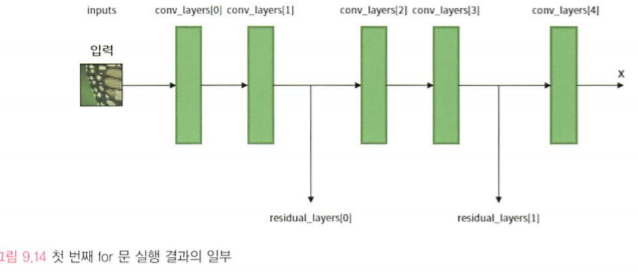

두번째for문 안에서는 홀수 번째의 디컨볼루션 레이어를 통과할 경우 잔류 레이어 리스트에 저장돼 있던 값을 residual_layers.pop()으로 뒤에서부터 하나씩 가져온다. 그 다음 합연산과 ReLU활성화 함수를 통과한 후 다음 디컨볼루션 레이어에 연결시킨다. 짝수 번째일때는 디컨볼루션 레이어만 연결한다.

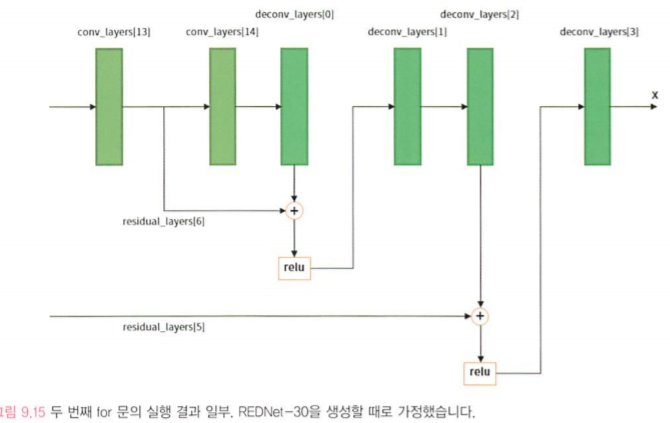

마지막으로 컬러이미지를 복원하는 3채널(RGB)의 디 컨볼루션 레이어를 x에 적용하면 레이어의 연산이 모두 끝난다.

tf.keras의 함수형 API로 Model을 만들기 위해서는 입력과 출력만 지정하면 된다. 입력인 input는 함수의 가장 앞에서 정의한 입력 레이어로, 출력인 ouptuts는 지금까지 레이어 연산을 쭉 따라온 변수 이름인 x로 넣고, model을 반환한다.      
모델을 만들었으니 컴파일만하면 학습시킬 수 있다. 고 해상도 이미지가 잘 복원 됐는지 알기위해서 특별한 측정값을 컴파일에 추가해서 테스트할 수 있다. 이 측정값은 PSNR, 즉 '신호 대 잡음비' 이다. 동일한 2개의 이미지를 PSNR로 계산하면 무한대의 값이 나오고, 보통 30 이상이면 좋은 값이다.       
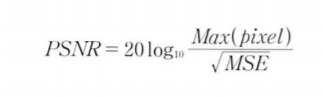

텐서플로에서는 이미 PSNR을 구현하는 tf.image.psnr(0이라는 함수가 이미 있어서 이것을 사용하겠다

In [ ]:
# 9.25 PSNR 정의
def psnr_metric(y_true, y_pred):
    return tf.image.psnr(y_true, y_pred, max_val=1.0)

metric은 분류 정확도(accuracy)처럼 tf.keras에 등록돼 있을 경우 그대로 사용하면 되지만 PSNR은 지원하지 않기 때문에 함수를 만들어준다. y_true는 정답에 해당하는 값이고 y_pred는 네트워크가 학습 결과 예측한 값이다. 이 둘의 tf.image.psnr()을 계산해서 반환하는 것이 psnr_metric() 함수의 역할이다.     

이제 위에서 준비한 REDNet() 함수로 네트워크를 초기화하고 컴파일해보겠다.

In [ ]:
# 9.26 REDNet-30 네트워크 초기화 및 컴파일
model = REDNet(15)
model.compile(optimizer=tf.optimizers.Adam(0.0001), loss='mse', metrics=[psnr_metric])
# 네트워크 시각화
# tf.keras.utils.plot_model(model)

REDNet()함수의 num_layers 인수로 15를 넣어서 REDNet-30 네트워크를 만든다. 컴파일할때 optimizer에는 0.0001의 학습률을 지정한 Adam을 사용하고 loss는 원본과 재구성된 이미지의 평균 제곱오차인 mse를 계산한다. 그리고 학습이 잘 되는지 알아보기 위한 측정값을 지정하는 metrics에는 앞에서 준비한 psnr_metric함수를 넣는다.

이제 학습을 시켜보겠다.

In [ ]:
# 9.27 REDNet-30 네트워크 학습
history = model.fit_generator(train_dataset, 
                              epochs=1000, 
                              steps_per_epoch=len(train_path)//16, 
                              validation_data=valid_dataset, 
                              validation_steps=len(valid_path), 
                              verbose=2)

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/1000
12/12 - 2s - loss: 0.2005 - psnr_metric: 8.3221 - val_loss: 0.2081 - val_psnr_metric: 8.4385
Epoch 2/1000
12/12 - 2s - loss: 0.1282 - psnr_metric: 10.3727 - val_loss: 0.0656 - val_psnr_metric: 12.8611
Epoch 3/1000
12/12 - 2s - loss: 0.0785 - psnr_metric: 12.4915 - val_loss: 0.0695 - val_psnr_metric: 12.6169
Epoch 4/1000
12/12 - 2s - loss: 0.0762 - psnr_metric: 12.3166 - val_loss: 0.0707 - val_psnr_metric: 13.1014
Epoch 5/1000
12/12 - 2s - loss: 0.0693 - psnr_metric: 12.6226 - val_loss: 0.0725 - val_psnr_metric: 12.7419
Epoch 6/1000
12/12 - 2s - loss: 0.0633 - psnr_metric: 12.9329 - val_loss: 0.0692 - val_psnr_metric: 12.8962
Epoch 7/1000
12/12 - 2s - loss: 0.0707 - psnr_metric: 12.6393 - val_loss: 0.0703 - val_psnr_metric: 12.7753
Epoch 8/1000
12/12 - 2s - loss: 0.0641 - psnr_metric: 12.8712 - val_loss: 0.0665 - val_psnr_metric: 13.0300
Epoch 9/1000
12/12 - 2s - loss: 0.0617 - psnr_metric: 13.3723 

Dataset를 이용한 학습은 fit()함수 대신 fit_generator()함수를 사용한다. 그리고 Dataset에 repeat()함수를 사용했기 대문에 한 번의 에포크에 몇개의 데이터를 학습시킬지를 지정하는 steps_per_epoch인 수를 설정해야한다. 훈련 데이터의 경우 batch size가 16이기 때문에 steps_per_epoch는 len(train_path)//16으로 , 훈련 데이터의 크기를 batch size로 나눈다.     
학습에는 train_dataset를 검증에는 valid_dataset를 사용하고 검증할 때는 검즌 데이터를 모두 한번씩 사용하도록 validation_steps=len(valid_path)로 지정한다. 1000에포크의 많은 양을 학습시키기 때문에 tf.keras에 있는 출력 제한에 걸리지 않도록 vervose=2로 설정해 진행상황 에니메이션을 생략하고 각 에포크의 결과만 출력한다.    
훈련데이터의 PSNR은 32정도, 검증데이터의 PSNR은 30정도가 나온다.

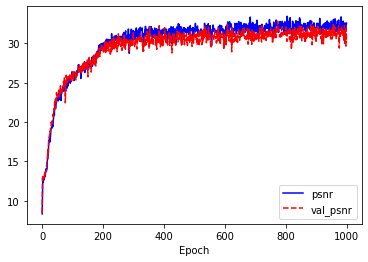

In [ ]:
# REDNet-30 네트워크 학습 결과 확인
import matplotlib.pyplot as plt
plt.plot(history.history['psnr_metric'], 'b-', label='psnr')
plt.plot(history.history['val_psnr_metric'], 'r--', label='val_psnr')
plt.xlabel('Epoch')
plt.legend()
plt.show()

훈련데이터와 검증 데이터의 PSNR모두 학습할 수록 증가하는 경향을 보인다. 학습된 네트워크가 실제 이미지를 어떻게 복원하는지 확인해보겠다

tf.Tensor(20.277544, shape=(), dtype=float32)
tf.Tensor(20.217585, shape=(), dtype=float32)


Text(0.5, 1.0, 'sr')

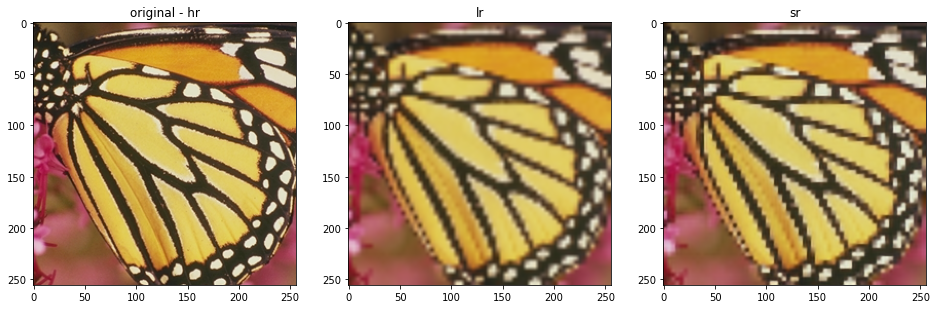

In [ ]:
# Set5의 나비 이미지 테스트
image_path = tf.keras.utils.get_file('butterfly.png', 'http://bit.ly/2oAOxgH')
img = tf.io.read_file(image_path)
img = tf.image.decode_jpeg(img, channels=3)
hr = tf.image.convert_image_dtype(img, tf.float32)

lr = tf.image.resize(hr, [hr.shape[0]//4, hr.shape[1]//4])
lr = tf.image.resize(lr, [hr.shape[0], hr.shape[1]])
predict_hr = model.predict(np.expand_dims(lr, axis=0))

print(tf.image.psnr(np.squeeze(predict_hr, axis=0), hr, max_val=1.0))
print(tf.image.psnr(lr, hr, max_val=1.0))


plt.figure(figsize=(16,6))
plt.subplot(1, 3, 1)
plt.imshow(hr)
plt.title('original - hr')

plt.subplot(1, 3, 2)
plt.imshow(lr)
plt.title('lr')

plt.subplot(1, 3, 3)
plt.imshow(np.squeeze(predict_hr, axis=0))
plt.title('sr')